In [0]:
!mkdir jena_climate

In [0]:
!cd jena_climate

In [3]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

--2020-01-09 12:47:54--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.227.99
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.227.99|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13568290 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  14.8MB/s    in 0.9s    

2020-01-09 12:47:56 (14.8 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13568290/13568290]



In [4]:
!unzip jena_climate_2009_2016.csv.zip

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  


In [0]:
import warnings
warnings.filterwarnings('ignore')

In [102]:
import os

data_dir = './'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [0]:
import numpy as np

# Data Time은 안들어가서 len(header) - 1
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(',')[1:]]
  float_data[i, :] = values

In [104]:
float_data.shape

(420551, 14)

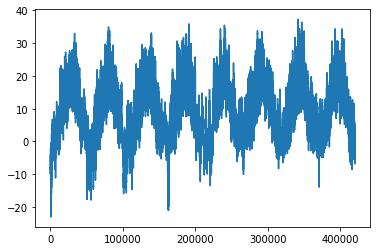

In [105]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)

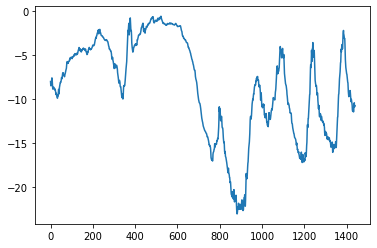

In [106]:
plt.plot(range(10*144), temp[:10*144])

In [0]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [0]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [0]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# 전체 검증 세트를 순회하기 위해 val_gen에서 추출할 횟수
val_steps = (300000 - 200001 - lookback) // batch_size

# 전체 테스트 세트를 순회하기 위해 test_gen에서 추출할 횟수
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [110]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
        
    result = np.mean(batch_maes)
    print(result)
    return result
    
celsius_mae = evaluate_naive_method() * std[1]
celsius_mae

0.2897359729905486


2.564887434980494

In [0]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/20





500/500 [==============================] - 156s 312ms/step - loss: 0.3073 - val_loss: 0.2706
Epoch 2/20
500/500 [==============================] - 146s 291ms/step - loss: 0.2823 - val_loss: 0.2679
Epoch 3/20
500/500 [==============================] - 146s 293ms/step - loss: 0.2784 - val_loss: 0.2698
Epoch 4/20
500/500 [==============================] - 146s 291ms/step - loss: 0.2723 - val_loss: 0.2647
Epoch 5/20
500/500 [==============================] - 146s 293ms/step - loss: 0.2687 - val_loss: 0.2630
Epoch 6/20
499/500 [============================>.] - ETA: 0s - loss: 0.2654

240

In [73]:
lookback

1440

In [74]:
step

6

In [75]:
steps

NameError: ignored